# Validating neurotransmitter colocalization in drug challenge CBF data

In [1]:
# general imports
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#data_dir = Path("/Volumes/ext/data/drug_mri")

## Create datasets

Data is not available for sharing. I will create a parcellated surrogate dataset in the future to share with you.

In [2]:
data_dir = Path("/Users/llotter/data/drug_mri/derivatives")

dset_paths = {}
            
# Risperidone 0.5mg + 2mg + Placebo
base_dir = data_dir / "risp"
rand_list = pd.read_csv(base_dir / "RandomizationList.csv")
rand_list = rand_list[rand_list["Cohort Name"] == "Group A Cohort"]
rand_list["Subject ID"] = rand_list["Subject ID"].astype(str)
rand_list["Subject ID"] = rand_list["Subject ID"].str[-4:]
session_mapping = {1: "placebo", 4: "risperidone low-dose", 5: "risperidone high-dose"}
for sub_dir in sorted(list(base_dir.glob("subject*"))):
    sub_id = sub_dir.name.split("_")[1]
    session_ids = rand_list.loc[rand_list["Subject ID"] == sub_id, "Treatment Code"].to_list()
    if len(session_ids) != 1 :
        print("Problem 1", sub_dir, session_ids)
        continue
    session_ids = [int(i) for i in str(session_ids[0])]
    session_names = [session_mapping[i] for i in session_ids]
    for drug, dir_name in zip(session_names, ["visit_A", "visit_B", "visit_C"]):
        
        # cbf
        sub_file = list((sub_dir / dir_name / "cASL1").glob("wx3D_ASL_non_contrast___m.nii.gz"))
        if len(sub_file) == 1:
            dset_paths[("cbf", drug, sub_dir.name)] = sub_file[0]
        else:
            print("Problem 2", sub_file)
            
        # rest
        sub_file = list((sub_dir / dir_name / "RS").glob("swufMRI_Resting_State_m_Frist24.nii.gz"))
        if len(sub_file) == 1:
            dset_paths[("rest", drug, sub_dir.name)] = sub_file[0]
        else:
            print("Problem 2", sub_file)
    
dset_paths = pd.Series(dset_paths).sort_index()
dset_paths

cbf   placebo               subject_1003    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1004    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1005    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1006    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1007    /Users/llotter/data/drug_mri/derivatives/risp/...
                                                                  ...                        
rest  risperidone low-dose  subject_1020    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1021    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1022    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1023    /Users/llotter/data/drug_mri/derivatives/risp/...
                            subject_1024    /Users/llotter/d

## Parcellate CBF data

In [3]:
from nispace.datasets import fetch_parcellation
from nispace.io import parcellate_data

parcellation = "Schaefer200MelbourneS2"

parc, parc_labels = fetch_parcellation(parcellation, return_loaded=True)
parc_cx, parc_cx_labels = fetch_parcellation(parcellation, return_loaded=True, cortex_only=True)
parc_sc, parc_sc_labels = fetch_parcellation(parcellation, return_loaded=True, subcortex_only=True)

dset_cbf = parcellate_data(
    dset_paths.loc["cbf",].to_list(),
    data_labels=dset_paths.loc["cbf",].index,
    data_space="mni152",
    parcellation=parc,
    parc_labels=parc_labels,
    parc_space="mni152",
    n_proc=-1
)
dset_cbf.head(5)

INFO | 20/06/24 12:06:41 | nispace: Loading parcellation: Schaefer200MelbourneS2 (n: 232, space: mni152, res: 1mm)
INFO | 20/06/24 12:06:41 | nispace: Loading parcellation: Schaefer200MelbourneS2 (n: 232, space: mni152, res: 1mm)
INFO | 20/06/24 12:06:41 | nispace: Removing 32 subcortical parcels. Will return Nifti1 object instead of path!
INFO | 20/06/24 12:06:41 | nispace: Loading parcellation: Schaefer200MelbourneS2 (n: 232, space: mni152, res: 1mm)
INFO | 20/06/24 12:06:41 | nispace: Removing 200 cortical parcels. Will return Nifti1 object instead of path!
INFO | 20/06/24 12:06:43 | nispace: Input type: list, assuming imaging data.
INFO | 20/06/24 12:06:43 | nispace: Parcellating imaging data.


Parcellating (-1 proc):   0%|          | 0/63 [00:00<?, ?it/s]

/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:806: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).as

INFO | 20/06/24 12:06:54 | nispace: Combined across images, 1 parcels had only background intensity and were set to nan (indices: [11]).
WARNING | 20/06/24 12:06:54 | nispace: Parcellated data contains nan values!


1_RH_SC_aHIP  2_RH_SC_pHIP  3_RH_SC_lAMY  4_RH_SC_mAMY  \
placebo subject_1003     51.090090     53.010870     56.212766     54.985507   
        subject_1004     45.866071     42.571429     45.936170     44.492754   
        subject_1005     50.723214     43.714286     48.319149     47.942029   
        subject_1006     36.693694     35.695652     31.127660     33.724638   
        subject_1007     39.504505     38.666667     43.851064     45.144928   

                      5_RH_SC_THA-DP  6_RH_SC_THA-VP  7_RH_SC_THA-VA  \
placebo subject_1003       63.706897       77.151515       70.921875   
        subject_1004       45.844828       51.366667       43.150442   
        subject_1005       50.172414       60.233333       51.904762   
        subject_1006       39.606557       47.258065       42.389831   
        subject_1007       44.233333       48.535714       44.213675   

                      8_RH_SC_THA-DA  9_RH_SC_NAc-shell  10_RH_SC_NAc-core  \
placebo subject_1003       63.705128          71.292683           69.15625   
        subject_1004       39.643836          66.390244           59.31250   
        subject_1005       44.818182          62.585366           55.46875   
        subject_1006       37.324675          47.048780           39.90625   
        subject_1007       39.958904          57.365854           48.28125   

                      ...  223_RH_CX_Default_PFCdPFCm_1  \
placebo subject_1003  ...                     86.671010   
        subject_1004  ...                     67.491803   
        subject_1005  ...                     74.813115   
        subject_1006  ...                     66.226537   
        subject_1007  ...                     65.474026   

                      224_RH_CX_Default_PFCdPFCm_2  \
placebo subject_1003                     86.459770   
        subject_1004                     72.811765   
        subject_1005                     73.690058   
        subject_1006                     64.232558   
        subject_1007                     64.619883   

                      225_RH_CX_Default_PFCdPFCm_3  \
placebo subject_1003                     76.323529   
        subject_1004                     80.758621   
        subject_1005                     72.454545   
        subject_1006                     58.966667   
        subject_1007                     60.266667   

                      226_RH_CX_Default_PFCdPFCm_4  \
placebo subject_1003                     74.806268   
        subject_1004                     52.576023   
        subject_1005                     60.968116   
        subject_1006                     58.960396   
        subject_1007                     50.485640   

                      227_RH_CX_Default_PFCdPFCm_5  \
placebo subject_1003                     64.651163   
        subject_1004                     30.845528   
        subject_1005                     41.265116   
        subject_1006                     43.465306   
        subject_1007                     34.986784   

                      228_RH_CX_Default_PFCdPFCm_6  \
placebo subject_1003                     69.012270   
        subject_1004                     48.554878   
        subject_1005                     59.579618   
        subject_1006                     49.500000   
        subject_1007                     41.452381   

                      229_RH_CX_Default_PFCdPFCm_7  \
placebo subject_1003                     71.459259   
        subject_1004                     44.349650   
        subject_1005                     46.529412   
        subject_1006                     51.639456   
        subject_1007                     44.882759   

                      230_RH_CX_Default_pCunPCC_1  \
placebo subject_1003                    75.055901   
        subject_1004                    48.929936   
        subject_1005                    58.224359   
        subject_1006                    44.925926   
        subject_1007                    46.666667   

               

## Parcellate rest data

In [4]:
from nilearn import maskers
from joblib import Parallel, delayed
from sklearn.covariance import ShrunkCovariance

def _precision_to_partial_pearson(precision_matrix):
    std = np.sqrt(np.diag(precision_matrix))
    pcor_matrix = -precision_matrix / np.outer(std, std)
    np.fill_diagonal(pcor_matrix, 1)
    return pcor_matrix

parcellater = maskers.NiftiLabelsMasker(
    labels_img=parc,
    resampling_target="data",
)
dset_rest = Parallel(n_jobs=-1)(
    delayed(parcellater.fit_transform)(f) 
    for f in tqdm(dset_paths.loc["rest",].iloc[:])
)
dset_fc = np.stack([np.corrcoef(arr.T) for arr in dset_rest])

dset_fc_sc2cx = {}
for lab in parc_sc_labels:
    dset_fc_sc2cx[lab] = pd.DataFrame(dset_fc[:, parc_labels.index(lab), :],
                                      columns=parc_labels,
                                      index=dset_cbf.index)
    
dset_gc = pd.DataFrame(
    np.mean(np.arctanh(dset_fc), axis=-1, where=~np.isclose(dset_fc, 1)),
    columns=parc_labels,
    index=dset_cbf.index
)

100%|██████████| 63/63 [00:52<00:00,  1.20it/s]
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_38696/3809545173.py:28: RuntimeWarning: divide by zero encountered in arctanh
  np.mean(np.arctanh(dset_fc), axis=-1, where=~np.isclose(dset_fc, 1)),


## Fetch reference data

In [5]:
from nispace.datasets import fetch_reference
from nispace.utils import mean_by_set_df

data_pet = fetch_reference("pet", collection="UniqueTracerSets", parcellation=parcellation,
                           verbose=False)
data_pet = mean_by_set_df(data_pet)
data_pet = data_pet.loc[['NMDA', 'mGluR5',
                         'GABAa', 'GABAa5',
                         '5HT1a', '5HT1b', '5HT2a', '5HT4', '5HT6', '5HTT',
                         'D1', 'D2', 'DAT', 'FDOPA',
                         'NET',
                         'A4B2', "M1", 'VAChT',
                         "MOR", "KOR", "CB1",
                         ]]
data_pet.head(5)

,1_RH_SC_aHIP,2_RH_SC_pHIP,3_RH_SC_lAMY,4_RH_SC_mAMY,5_RH_SC_THA-DP,6_RH_SC_THA-VP,7_RH_SC_THA-VA,8_RH_SC_THA-DA,9_RH_SC_NAc-shell,10_RH_SC_NAc-core,...,223_RH_CX_Default_PFCdPFCm_1,224_RH_CX_Default_PFCdPFCm_2,225_RH_CX_Default_PFCdPFCm_3,226_RH_CX_Default_PFCdPFCm_4,227_RH_CX_Default_PFCdPFCm_5,228_RH_CX_Default_PFCdPFCm_6,229_RH_CX_Default_PFCdPFCm_7,230_RH_CX_Default_pCunPCC_1,231_RH_CX_Default_pCunPCC_2,232_RH_CX_Default_pCunPCC_3
map,,,,,,,,,,,,,,,,,,,,,
NMDA,0.856087,1.097310,0.536432,0.121522,1.525484,2.602237,2.319482,2.372884,1.386867,1.115944,...,0.438159,0.556342,-1.043219,-0.690124,-1.176394,0.464247,-0.154404,0.803797,1.085621,0.564515
mGluR5,-0.594320,-0.965934,-0.406479,-1.308930,-1.474559,-1.125907,-2.106378,-2.245597,1.075615,1.380771,...,1.380193,1.563372,-0.988069,0.736622,-0.235553,0.605265,-0.155141,0.208191,1.542228,1.429053
GABAa,-1.276636,-0.749437,-1.104047,-2.056812,-2.473823,-2.582570,-2.403070,-2.482388,-0.449335,-1.260929,...,0.927037,1.449189,-0.476172,0.141214,-0.250956,0.550575,-0.019053,0.766259,1.367796,0.948227
GABAa5,1.648608,1.588389,1.019051,1.007363,-1.378177,-1.662808,-1.910507,-1.615236,3.656158,0.114295,...,2.175274,2.526060,1.084769,0.782888,0.288683,0.812587,0.379886,0.307816,0.718544,0.259701
5HT1a,2.898136,1.381909,0.207822,0.039671,-1.900556,-2.053603,-1.864888,-2.205842,-1.147610,-2.470940,...,0.843244,0.881194,0.140186,0.340022,0.074204,0.060396,-0.180267,-0.405400,-0.055040,-0.218997


## Coloc. results

In [6]:
dset_joint = pd.concat(
    [dset_cbf, dset_gc], 
    keys=["cbf", "gc"]
)
dset_joint

1_RH_SC_aHIP  2_RH_SC_pHIP  \
cbf placebo              subject_1003     51.090090     53.010870   
                         subject_1004     45.866071     42.571429   
                         subject_1005     50.723214     43.714286   
                         subject_1006     36.693694     35.695652   
                         subject_1007     39.504505     38.666667   
...                                             ...           ...   
gc  risperidone low-dose subject_1020      0.301419      0.250006   
                         subject_1021      0.196915      0.365109   
                         subject_1022      0.210679      0.346107   
                         subject_1023      0.207931      0.242889   
                         subject_1024      0.244012      0.279925   

                                       3_RH_SC_lAMY  4_RH_SC_mAMY  \
cbf placebo              subject_1003     56.212766     54.985507   
                         subject_1004     45.936170     44.492754   
                         subject_1005     48.319149     47.942029   
                         subject_1006     31.127660     33.724638   
                         subject_1007     43.851064     45.144928   
...                                             ...           ...   
gc  risperidone low-dose subject_1020      0.494434      0.436781   
                         subject_1021      0.330230      0.318208   
                         subject_1022      0.260551      0.264900   
                         subject_1023      0.279288      0.361606   
                         subject_1024      0.188637      0.210184   

                                       5_RH_SC_THA-DP  6_RH_SC_THA-VP  \
cbf placebo              subject_1003       63.706897       77.151515   
                         subject_1004       45.844828       51.366667   
                         subject_1005       50.172414       60.233333   
                         subject_1006       39.606557       47.258065   
                         subject_1007       44.233333       48.535714   
...                                               ...             ...   
gc  risperidone low-dose subject_1020        0.316090        0.346345   
                         subject_1021        0.497361        0.463380   
                         subject_1022        0.311153        0.305382   
                         subject_1023        0.270115        0.200824   
                         subject_1024        0.344231        0.273566   

                                       7_RH_SC_THA-VA  8_RH_SC_THA-DA  \
cbf placebo              subject_1003       70.921875       63.705128   
                         subject_1004       43.150442       39.643836   
                         subject_1005       51.904762       44.818182   
                         subject_1006       42.389831       37.324675   
                         subject_1007       44.213675       39.958904   
...                                               ...             ...   
gc  risperidone low-dose subject_1020        0.354349        0.321563   
                         subject_1021        0.347498        0.202981   
                         subject_1022        0.241390        0.268939   
                         subject_1023        0.253525        0.260173   
                         subject_1024        0.314014        0.328397   

                                       9_RH_SC_NAc-shell  10_RH_SC_NAc-core  \
cbf placebo              subject_1003          71.292683          69.156250   
                         subject_1004          66.390244          59.312500   
                         subject_1005          62.585366          55.468750   
                         subject_1006          47.048780          39.906250   
                         subject_1007          57.365854          48.281250   
...                                                  ...                ...   
gc  risperidone low-dose subject_1020           0.432182           0.35342

In [7]:
from nispace import NiSpace
from nispace.utils import parc_vect_to_vol


nsp_obj = {"wb": {}, "cx": {}, "sc": {}}
plot_vols = {"wb": {}, "cx": {}, "sc": {}}
es_lims = {"wb": {}, "cx": {}, "sc": {}}
n_perm = 10000


for study, drug, placebo in tqdm([("cbf", "risperidone low-dose", "placebo"),
                                  ("cbf", "risperidone high-dose", "placebo"),
                                  ("gc", "risperidone low-dose", "placebo"),
                                  ("gc", "risperidone high-dose", "placebo")]):
    
    dset_drug = dset_joint.loc[(study, drug, slice(None)), :]
    dset_placebo = dset_joint.loc[(study, placebo, slice(None)), :]
    sessions = [0] * len(dset_drug) + [1] * len(dset_placebo)
    subjects = dset_drug.index.get_level_values(-1).tolist() + dset_placebo.index.get_level_values(-1).tolist()
    if len(dset_drug) != len(dset_placebo):
        ValueError(f"{study}: {drug} vs. {placebo} have different number of subjects")
    
    dset_drug_placebo = pd.concat([dset_drug, dset_placebo], axis=0)
    
    for parc_type, parc_sub, parc_labels_sub in [("wb", parc, parc_labels),
                                                 ("cx", parc_cx, parc_cx_labels), 
                                                 ("sc", parc_sc, parc_sc_labels)]:
        
        nsp = NiSpace(
            x=data_pet[parc_labels_sub],
            y=dset_drug_placebo[parc_labels_sub],
            z="gm",
            parcellation=parc_sub,
            parcellation_labels=parc_labels_sub,
            parcellation_space="mni152",
            n_proc=-1,
            verbose=False
        ).fit()
        
        kwargs = {
            "method": "spearman",
            "Y_transform": "pairedcohen(a,b)"
        }
        
        nsp.transform_y(kwargs["Y_transform"], groups=sessions, subjects=subjects)
        
        nsp.colocalize(**kwargs)
        
        nsp.permute("groups", **kwargs, n_perm=n_perm, seed=42)
        
        #nsp.plot(**kwargs, title=f"{drug} - {placebo}", permute_what="groups")

        # save nsp object
        nsp_obj[parc_type][(study, drug)] = nsp
        # get es vector
        es = nsp.get_y(kwargs["Y_transform"]).squeeze()
        # save volume
        plot_vols[parc_type][(study, drug)] = parc_vect_to_vol(es, parc_sub)
        # save min/max
        es_lims[parc_type][(study, drug)] = (es.min(), es.max())

  0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 75%|███████▌  | 3/4 [01:38<00:32, 32.85s/it]/opt/anaconda3/envs/nsp309/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 4/4 [02:18<00:00, 34.73s/it]


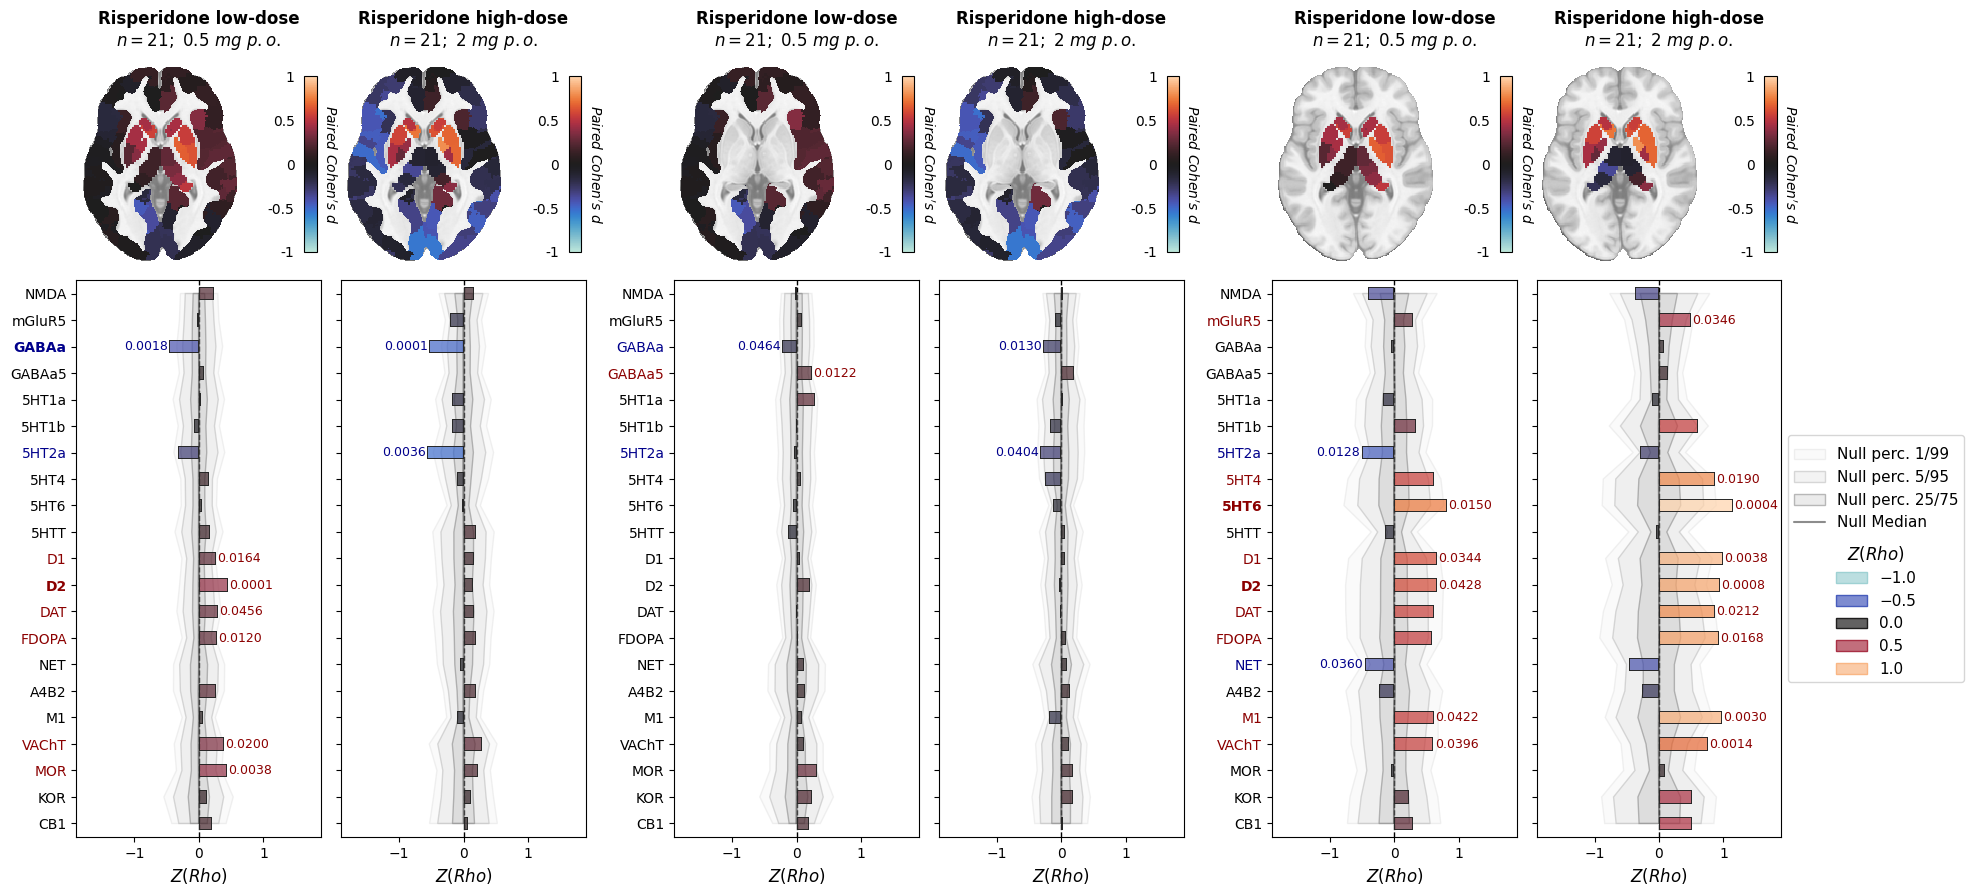

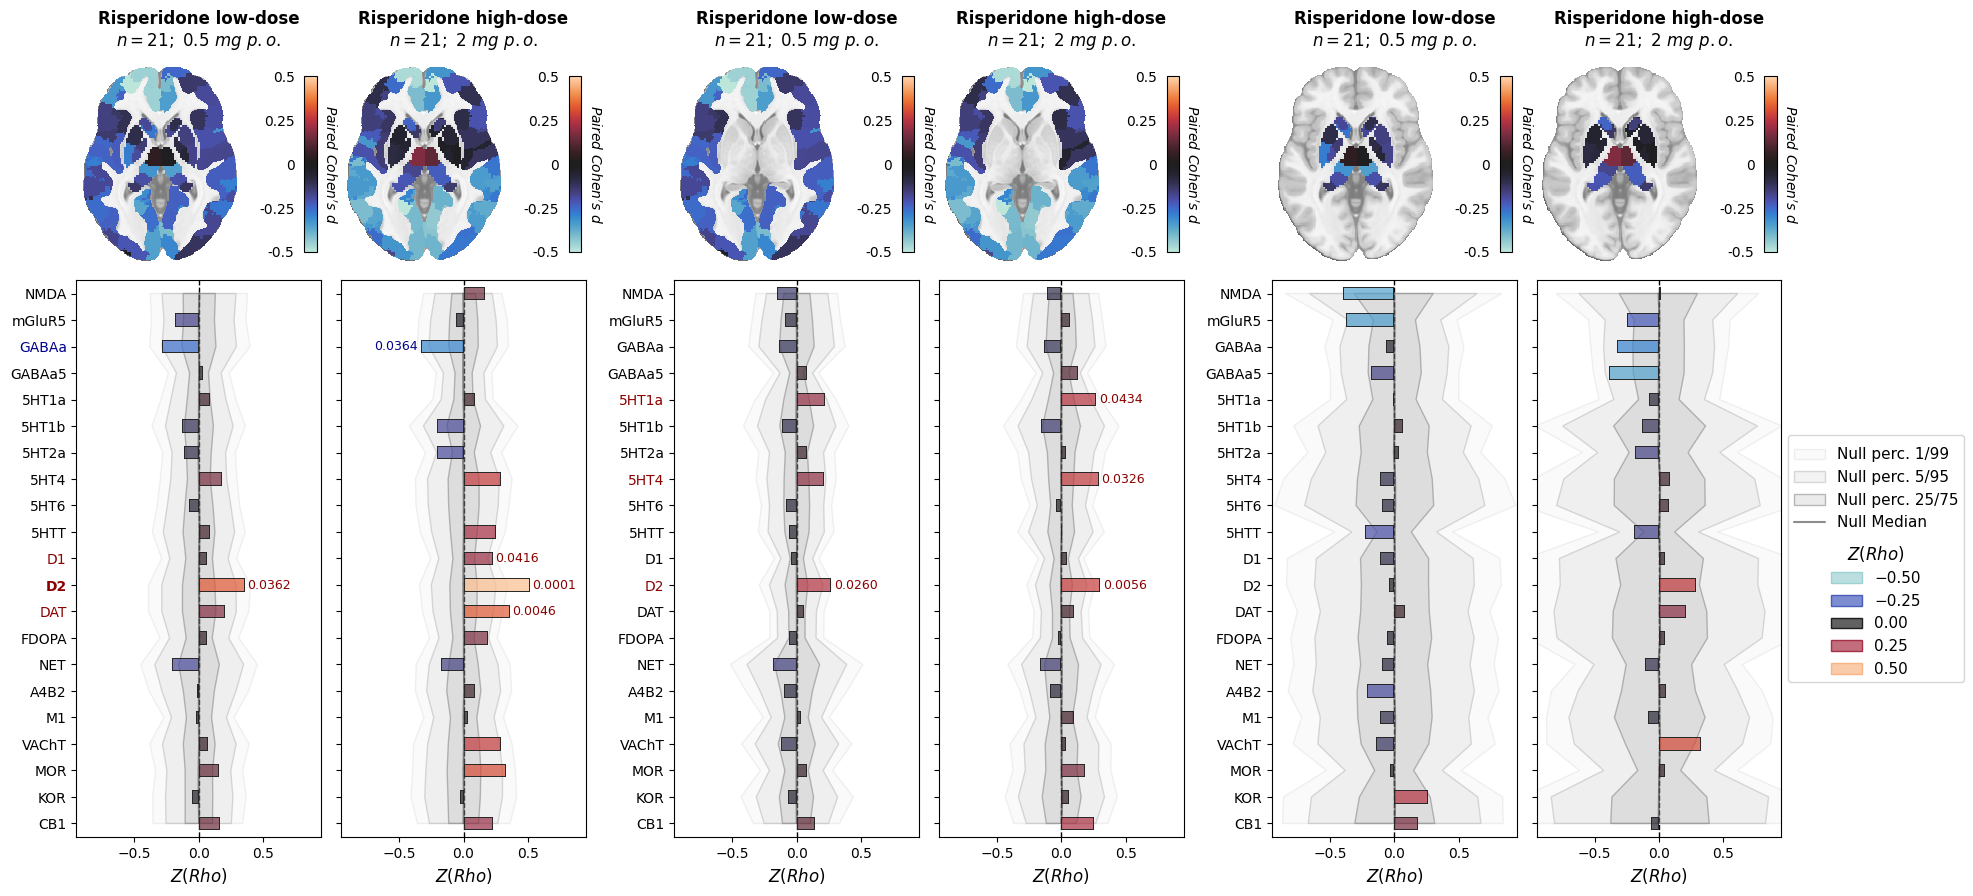

In [9]:
from nilearn.plotting import plot_stat_map
from nispace.datasets import fetch_template

drug_info = {
    "risperidone low-dose": f"n={dset_joint.loc[('cbf', 'risperidone low-dose', slice(None)), :].shape[0]}; 0.5 mg p.o.",
    "risperidone high-dose": f"n={dset_joint.loc[('cbf', 'risperidone high-dose', slice(None)), :].shape[0]}; 2 mg p.o."
}

for metric, x_lims, rho_lims, es_absmax in [("cbf", (-1.9, 1.9), (-1.1, 1.1), 1), 
                                            ("gc", (-0.95, 0.95), (-0.55, 0.55), 0.5)]:
    
    #es_absmax = max(abs(np.concatenate([es_lims[parc_type][(metric, drug)] for drug in drug_info])))
    
    fig, axes = plt.subplots(2, 6+2, figsize=(22, 10), sharex="row",
                             gridspec_kw={"height_ratios": (0.35, 1), 
                                          "width_ratios": (1,1, 0.2, 1,1, 0.2, 1,1),
                                          "hspace": 0.05,
                                          "wspace": 0.1})
    
    for c, parc_type in [(0, "wb"), 
                         (3, "cx"), 
                         (6, "sc")]:
        
        if c < 6:
            axes[0, c+2].set_axis_off()
            axes[1, c+2].set_axis_off()
        
        for cc, drug in enumerate(drug_info):
            
            nsp = nsp_obj[parc_type][(metric, drug)]
            vol = plot_vols[parc_type][(metric, drug)]
        
            # title
            ax = axes[0, c+cc]
            ax.set_title(
                drug.capitalize() + "\n$" + drug_info[drug].replace(" ", "\ ") + "$",
                weight="semibold",
                pad=15,
                size=12
            )
        
            # brain
            plot = plot_stat_map(
                vol, 
                bg_img=fetch_template("mni152"),
                black_bg=False,
                display_mode="z",
                cut_coords=[0],
                axes=ax, 
                cmap="icefire", vmax=es_absmax,
                colorbar=True,
                annotate=False
            )
            plot._colorbar_ax.set_ylabel("$Paired\ Cohen's\ d$", rotation=-90, va="bottom")

            # bars
            ax = axes[1, c+cc]
            nsp.plot(
                **kwargs, ax=ax, fig=fig, permute_what="groups", verbose=False, show=False, title=None,
                plot_kwargs={
                    "limits": {
                        "x": x_lims, 
                        "color": rho_lims
                    },
                    "legend": {
                        "plot": True if ax.get_subplotspec().is_last_col() else False,
                        "kwargs": {"title": "$Z(Rho)$"}
                    }
                },
                nullplot_kwargs={
                    "legend": {
                        "plot": True if ax.get_subplotspec().is_last_col() else False,
                        "kwargs": {"title": "$Null distribution$"}
                    }
                }
            )
            ax.set_xlabel("$Z(Rho)$", size=12)
            
            # p values
            p_values = nsp.get_p_values(permute_what="groups", **kwargs).loc["mean"]
            coloc_values = nsp.get_colocalizations(**kwargs).mean()
            for p_y_pos, (lab, p_val, coloc_val) in enumerate(zip(axes[1, c].get_yticklabels(), p_values, coloc_values)):
                if p_val < 0.05:
                    lab.set_color("darkred" if coloc_val > 0 else "darkblue")
                    if p_val <= 0.001:
                        lab.set_weight("bold")
                    ax.annotate(
                        f"{p_val:.04f}",
                        xy=(coloc_val + (0.02 if coloc_val > 0 else -0.02), p_y_pos),
                        size=9,
                        color="darkred" if coloc_val > 0 else "darkblue",
                        ha="left" if coloc_val > 0 else "right",
                        va='center'
                    )
                    
            if cc == 1:
                ax.set_yticklabels([])
        
    # save
    fig.savefig(f"drug_challenge_plot_{metric}.pdf", bbox_inches="tight", dpi=300)
    plt.show()